# Task 1

## Introduction

### Swap Test

In this task, we were asked to use the [swap test](https://en.wikipedia.org/wiki/Swap_test) for reproducing randomly generated quantum states. The circuit for the swap test is the following:

<img src="./images/swap_test.png" alt="swap_test" width="300"/>

The basic idea relies on the probability of measuring zero at the first qubit which is described by the following formula:

$$ P\left( \text{First qubit} = 0 \right) = \frac{1}{2}\left( \langle\phi|\langle\psi| + \langle\psi|\langle\phi| \right) \frac{1}{2}\left( |\phi\rangle|\psi\rangle + |\psi\rangle|\phi\rangle \right) = \frac{1}{2} + \frac{1}{2}|\langle \psi | \phi \rangle|^2 $$


If $ \psi $ and $ \phi $ are orthogonal ($ |\langle \psi | \phi \rangle|^2 = 0 $), then the probability of measuring 0 is $ \frac{1}{2} $. If the states are equal ($ |\langle \psi | \phi \rangle|^2 = 1 $), then the probability of measuring 0 is $ 1 $. Thus, the probabilities fluctuate between $ \frac{1}{2} $ for less similar states, and $ 1 $ for more similar ones.

### Variational Circuits

There is a group of quantum algorithms called Variational Quantum Algorithms which rely on the Variational Method for Quantum Mechanics (whose explanation are beyond the scope of this exercise). These algorithms are ideal for "Noise Intermediate-Scale Quantum" (NISQ) - which is the current era of quantum processors - as they are shallow and don't require a lot of qubits.

The main idea is to use a circuit which has some tunable parameters (such as rotations by some angles) in order to optimize its behavior. This circuit is called an *ansatz*.

The objective of the ansatz is for it to be capable to approximate whatever quantum state you want.

## Exercise 1

> Provide a variational (also called parametric) circuit which is able to generate the most general 1 qubit state. By most general 1 qubit state we mean that there exists a set of the parameters in the circuit such that any point in the Bloch sphere can be reached. Check that the circuit works correctly by showing that by varying randomly the parameters of your circuit you can reproduce correctly the Bloch sphere.

### Reasoning

As we need a parametric circuit to generate the most general 1 qubit state, the immediate answer would be to use the U3 gate:

$$ U3(\theta, \phi, \lambda) = \begin{pmatrix}
\cos{\left( \frac{\theta}{2} \right)} & -e^{i\lambda} \sin{\left( \frac{\theta}{2} \right)}\\
e^{i\phi} \sin{\left( \frac{\theta}{2} \right)} & e^{i(\phi + \lambda) \cos{\left( \frac{\theta}{2} \right)}}
\end{pmatrix} $$

Here, we can generate every 1-qubit state using 3 parameters. The problem with a circuit using only this gate is that it uses 3 parameters and it is decomposed into various other rotation gates.

Instead of using $ U3 $, let's have a look at the bloch sphere:

<img src="./images/bloch_sphere.jpg" alt="bloch_sphere" width="300"/>

Starting from $ |0\rangle $ it is clear that we can achieve every point on its surface by using two rotations: one rotation around X (RX) or (RY) between $ 0 $ and $ \pi $, and another rotation around Z (RZ) between $ 0 $ and $ 2\pi $. The effect of the rotation around Y would result in:

<img src="./images/bloch_y.jpg" alt="bloch_y" width="300"/>

The second rotation (RZ) would complete the whole sphere. Actually, using two different rotations (around different axis) would have the same result, the only caveat is not to use the RZ first as we are starting with qubits on the $ | 0 \rangle $ state.

All of this is important considering that we cannot distinguish between states that differ just by a global phase. Thus, being able to generate the complete bloch sphere is equivalente to generating the most general 1-qubit state.


### Coding

First, we import some general libraries and the ones specific to qiskit.

In [8]:
import numpy as np
from random import random

import matplotlib as mpl
import matplotlib.pyplot as plt

from qiskit import *
from qiskit.visualization import plot_bloch_vector, plot_bloch_multivector
from qiskit.quantum_info import random_statevector # Creating random vectors for testing
from qiskit.circuit.library import CSwapGate # Import CSwapGate
%matplotlib inline

In [9]:
# Graphing style
print(plt.style.available)
mpl.style.use(['ggplot'])

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


Defining two backends: one for statevectors (for the bloch sphere) and the other for getting the counts.

In [10]:
backend_qasm = BasicAer.get_backend("qasm_simulator")
backend_bloch = Aer.get_backend('statevector_simulator')

This function defines the variational circuit using two parameters: one for the rotation in X and the other for the  rotation in Y.

In [12]:
def quantum_state_preparation(circuit, parameters, n=1):
    """Creates a variational circuit with a RY and RZ. 
    
    Parameters
    ----------
    circuit : qiskit.QuantumCircuit
    
    parameters : float[]
        List of the parameters for each of the rotations.
        parameters[0] corresponds to theta for RX
        parameters[1] corresponds to theta for RY
        
    Returns
    -------
    circuit
        a qiskit.QuantumCircuit with the variational circuit.
    """
    
    q = circuit.qregs[0] # q is the quantum register where the info about qubits is stored
    circuit.ry(parameters[0], q[n]) 
    circuit.rz(parameters[1], q[n])
    circuit.barrier()
    
    return circuit

### Testing

For testing if my circuit recreates every possible state I create 400 (or whatever number) random parameters (from $ 0 $ to $ 2\pi $) to pass them to the `quantum_state_preparation` function. Then, I graph all of them on the same bloch sphere.

In [14]:
# Library for transforming statevectors into coordinates.
from qiskit.visualization.utils import _bloch_multivector_data

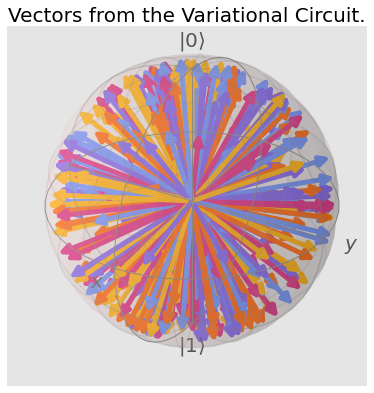

In [15]:
outs = []
out_coords = []
for i in range(400):
    qr = QuantumRegister(1)
    cr = ClassicalRegister(1) 

    circuit = QuantumCircuit(qr, cr)

    #parameters = 2*np.pi*np.random.rand(2)
    parameters = [np.pi*np.random.rand(), 2*np.pi*np.random.rand()]

    circuit = quantum_state_preparation(circuit, parameters, n=0)

    backend = Aer.get_backend('statevector_simulator')
    outs.append(execute(circuit, backend).result().get_statevector())
    
    
for out in outs:
    out_coords.append(_bloch_multivector_data(out)[0])
plot_bloch_vector(out_coords, title="Vectors from the Variational Circuit.")

As shown in the bloch sphere, the implemented circuit does indeed cover the whole bloch sphere. Thus the **first task** is achieved.

## Exercise 2

> Use the circuit built in step 1) and, using the SWAP test, find the best choice of your parameters to reproduce a randomly generated quantum state made with 1 qubit.

### Reasoning

Here the task is to use the variational circuit in conjunction with the swap test to reconstruct a random vector.

The main point of the VQA is to define the cost function. As written before, this probability is:

$$ P\left( \text{First qubit} = 0 \right) = \frac{1}{2} + \frac{1}{2}|\langle \psi | \phi \rangle|^2 $$

Thus, we can get the inner product of both states as:

$$ |\langle \psi | \phi \rangle|^2 = 2 \left( P\left( \text{First qubit} = 0 \right) - \frac{1}{2} \right) $$

Where the probability is approximated by doing several measurements.

Then, the inner product value is the one I want to maximize as it reaches a value of $ 1 $ when the states are the same and $ 0 $ when they are orthogonal. Thus, as a cost function we can use 1 minus that value.

$$ \textit{Cost} = 1 - |\langle \psi | \phi \rangle|^2 $$

Lastly, we can use a general optimizer to obtain the parameters that minimize this value. As suggested in the Qiskit VQE implementation, I use COBYLA.

### Coding

First, I define the Swap test circuit twofold. The first uses the CSwapGate from qiskit and the other one uses an equivalent circuit using Controlled-X and Toffoli gates.

In [16]:
def swap_test(circuit, qs=[0,1,2]):
    """Implements the Swap Test using the CSwapGate
    
    Parameters
    ----------
    circuit : qiskit.QuantumCircuit
    
    qs : int[]
        List specifying the control qubit and the controlled ones.
        qs[0] corresponds to the control qubit.
        
    Returns
    -------
    circuit
        a qiskit.QuantumCircuit with the swap test circuit.
    """
    
    q = circuit.qregs[0]
    circuit.h(q[qs[0]])
    circuit.append(CSwapGate(), [q[qs[0]], q[qs[1]], q[qs[2]]])
    circuit.h(q[qs[0]])
    
    return circuit

In [17]:
def alt_swap_test(circuit, qs=[0,1,2]):
    """Implements the Swap Test using CX and the CCX gates.
    
    Parameters
    ----------
    circuit : qiskit.QuantumCircuit
    
    qs : int[]
        List specifying the control qubit and the controlled ones.
        qs[0] corresponds to the control qubit.
        
    Returns
    -------
    circuit
        a qiskit.QuantumCircuit with the swap test circuit.
    """
    q = circuit.qregs[0]
    circuit.h(q[qs[0]])
    circuit.cx(q[qs[2]], q[qs[1]])
    circuit.ccx(q[qs[0]], q[qs[1]], q[qs[2]])
    circuit.cx(q[qs[2]], q[qs[1]])
    circuit.h(q[qs[0]])
    
    return circuit

Here, I create a random statevector for doing the tests. This cell must be re-run if you want to test with another statevector (or explicitly give another one).


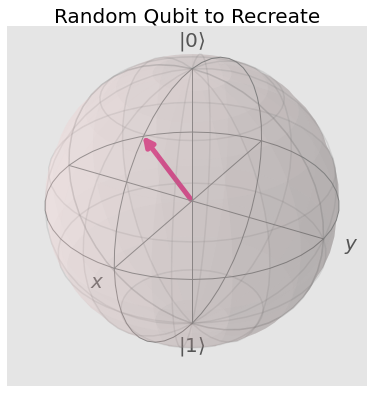

In [19]:
random_vec = random_statevector(2).data
plot_bloch_vector(_bloch_multivector_data(random_vec), title="Random Qubit to Recreate")

Next, I create the variational circuit including the quantum state preparation (the variational part) and the swap test. At the end, I include the measurement of the control qubit.

As this function will be used for the optimizer, I passed as a global variable the random vector (created in the cell above).

In [20]:
def variational_circuit(parameters):
    """Creates the variational circuit with the swap test.
    
    Parameters
    ----------
    parameters : float[]
        list of parameters for the rotations (RX and RY).
        
    Returns
    -------
    circuit
        a qiskit.QuantumCircuit with the swap test circuit.
    """
    
    qr = QuantumRegister(3)
    cr = ClassicalRegister(1)
    
    circuit = QuantumCircuit(qr, cr)
    initial_state = circuit.initialize(random_vec, 2)
    circuit.barrier()
    
    circuit = quantum_state_preparation(circuit, parameters)
    circuit = swap_test(circuit)
    circuit.measure(qr[0], cr[0])
    
    return circuit

Now, I define the objective function as previously established. I create the variational circuit, then execute it for some number of shots (8192), coun the zero values and divide them by the total to obtain an approximate of the probability of measuring zero. Finally, I return the cost function.

In [21]:
NUM_SHOTS = 8192

def objective_function(parameters):
    """Returns the cost function for the variational circuit + swap test
    
    Parameters
    ----------
    parameters : float[]
        list of parameters for the rotations
        
    Returns
    -------
    cost
        cost function calculated as 1 - 2*(prob(0) - 1/2)
    
    """
    circuit = variational_circuit(parameters)
        
    job = execute(circuit, backend_qasm, shots=NUM_SHOTS)
    result = job.result()
    counts = result.get_counts()
    zero_prob = counts['0'] / NUM_SHOTS
    
    # prob is 1/2 + 1/2(<psi|theta>)^2
    cost = 1 - 2*(zero_prob - (1/2))
    return cost

### Testing

In this part, I create the optimizer instance as well as initializing the parameters to random values (in the aforementioned range). For the COBYLA optimizer, I defined a maximum number of iterations of 500 as well as a tolerance of 0.0001.

In [22]:
from qiskit.aqua.components.optimizers import COBYLA

In [23]:
optimizer = COBYLA(maxiter=500, tol=0.0001)
parameters = 2*np.pi*np.random.rand(2)
ret = optimizer.optimize(num_vars=2, objective_function=objective_function, initial_point=parameters)

In [24]:
objective_function(ret[0])

0.0

Showing the final circuit:

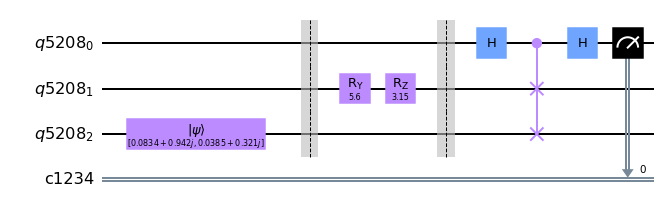

In [25]:
circuit = variational_circuit(ret[0])
circuit.draw(output="mpl")

Showing all the qubits from the circuit. The second qubit is the reconstructed state and the third one is the random qubit (objective qubit).

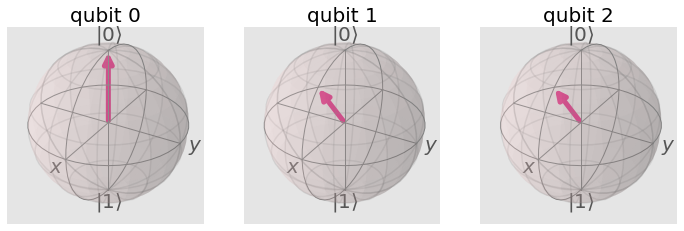

In [26]:
out = execute(circuit, backend_bloch).result().get_statevector()
plot_bloch_multivector(out)

As shown by both the bloch sphere and the cost function, my variational circuit correctly reconstructs whatever random 1-qubit state. Thus, the **second task** is completed.

## Exercise 3

> Suppose you are given with a random state, made by N qubits, for which you only know that it is a product state and each of the qubits are in the state | 0 > or | 1>. By product state we mean that it can be written as the product of single qubit states, without the need to do any summation. For example, the state
 
> |a> = |01>
 Is a product state, while the state
 |b> = |00> + |11>
 Is not.

> Perform a qubit by qubit SWAP test to reconstruct the state. This part of the problem can be solved via a simple grid search.


### Reasoning

The idea here is that we will be receiving a qubit state that can be stated as a string of 0s and 1s. Then, by doing swap tests we need to reconstruct the original individual qubits that created the product state.

If we receive the N qubits, we can solve this problem in two manners:

1. Doing the swap test comparing the complete N-qubit state against a proposed N-qubit state. This can be done using a grid search with all the possible N-qubit product states ($ 2^n $ different states). Actually, as all the product states are orthogonal, the probability of measuring zero will be $ \frac{1}{2} $ (for $ 2^N - 1 $ states) and $ 1 $ for just the exact state. Thus, this probability doesn't give information of how near we are to the solution, and that's why we would need to do a grid search with all the possible states.

2. Doing the swap test for each of the N-qubits. Here, we can propose a $ | 0 \rangle $ for it to be compared against every qubit from the given quantum state. As it can only be 0 or 1, either the probability of measuring 0 will be $ 0 $ o $ 1 $. By doing the experiment for some shots (not nearly as much for the previous exercise), if the proportion of zeros is near 1, we know that the qubit is a $ | 0 \rangle $. This approach only has to be done $ N $ times (multiplied by the number of shots); thus, this was the method that I chose. Lastly, the number of shots depends on the computer; for ideal computers (no noise) we can use less shots as you would never get a measurement of "1" if the values are orthogonal.

### Coding

Here, I define the function ``random_product`` where I receive the string of 0s and 1s that composes the product quantum state. Then, I cycle through them, code them into a qubit, and do the swap test against a $ | 0 \rangle $ state. This circuit is executed 50 times (aribtrary proposed) for calculating the probability of measuring zero, if this probability is less than 0.9, then the qubit from the product state is a $ | 1 \rangle $, if not, then it is a $ | 0 \rangle $.

In [37]:
def random_product(qubits):    
    recon_qubits = []
    
    for idx, qubit in enumerate(qubits):
        qr = QuantumRegister(3)
        cr = ClassicalRegister(1)
        
        circuit = QuantumCircuit(qr, cr)
        if qubit == "1":
            circuit.x(qr[1])
        
        circuit = alt_swap_test(circuit)
        circuit.measure(qr[0], cr[0])
        
        job = execute(circuit, backend_qasm, shots=50)
        result = job.result()
        counts = result.get_counts()
        zero_prob = counts['0'] / 50
        
        if zero_prob < 0.9:
            recon_qubits.append("1")
        else:
            recon_qubits.append("0")
        
    return recon_qubits

### Testing

For testing the code, we can send random bit strings of 0s and 1s and compare them against the reconstructed states.

In [38]:
# Function for splitting binary strings
def split(word): 
    return [char for char in word]  

In [42]:
testing_product_states = [
    "10100", 
    "1101", 
    "111001001", 
    "0010010"]

for state in testing_product_states:
    recon_state = random_product(split(state))
    
    print("Product State: " + state)
    print("Reconstructed State: " + "".join(recon_state) + "\n")

Product State: 10100
Reconstructed State: 10100

Product State: 1101
Reconstructed State: 1101

Product State: 111001001
Reconstructed State: 111001001

Product State: 0010010
Reconstructed State: 0010010



As it is shown, I correctly reconstructed the product states using the swap test per qubit. Thus, the **exercise 3** is completed